In [32]:
import numpy as np
my_string="CCGGAATCGATCTATCGT"
my_array=np.array(list(my_string))
onehot_encode = np.zeros((len(my_array),4), dtype=int)
base_dict = {'A':0, 'C':1, 'G':2, 'T':3}
for i in range(len(my_array)):
    onehot_encode[i, base_dict[my_array[i]]]=1
print(onehot_encode)

[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [2]:
from Bio import motifs
from Bio.Seq import Seq

DNA=""
instances = [Seq("AAAA"), Seq("CTAT"), Seq("GCCC"),Seq("TGAC"), Seq("CTAT"), Seq("GCCC"),Seq("TGAC"), Seq("CTAT"), Seq("GCCC"),Seq("TGAC"), Seq("CTAT"), Seq("GCCC")]
m = motifs.create(instances)
pfm = m.counts
pwm = m.counts.normalize(pseudocounts=0.5)
print (pfm)
print (pwm)

        0      1      2      3
A:   1.00   1.00   8.00   1.00
C:   4.00   4.00   4.00   7.00
G:   4.00   3.00   0.00   0.00
T:   3.00   4.00   0.00   4.00

        0      1      2      3
A:   0.11   0.11   0.61   0.11
C:   0.32   0.32   0.32   0.54
G:   0.32   0.25   0.04   0.04
T:   0.25   0.32   0.04   0.32



In [34]:
pwm_arr = np.array(list(pwm.values())).transpose()
s1 = np.multiply(onehot_encode[0:4,], pwm_arr)
s2 = np.multiply(onehot_encode[1:5,], pwm_arr)
print(np.log(np.prod(np.sum(s1, axis=1)))) #s1 score
print(np.log(np.prod(np.sum(s2, axis=1)))) #s2 score

-4.375294174159523
-5.286413117631284


In [35]:
import numpy as np
seq_length = 20
num_sample = 1000
motif_pwm = np.array([[0.21,0.19,0.17,0.16],
                      [0.28,0.33,0.25,0.28],
                      [0.34,0.30,0.38,0.36],
                      [0.18,0.17,0.20,0.21]
                     ])
pwm = np.hstack([np.ones((4, 8)), motif_pwm, np.ones((4, 8))])
pos = np.array([np.random.choice( ['A', 'C', 'G', 'T'], num_sample,
                                  p=pwm[:,i]/sum(pwm[:,i])) for i in range(seq_length)]).transpose()
neg = np.array([np.random.choice( ['A', 'C', 'G', 'T'], num_sample,
                                  p=np.array([1,1,1,1])/4) for i in range(seq_length)]).transpose()

print(pos.shape)



(1000, 20)


In [36]:
base_dict = {'A':0, 'C':1, 'G':2, 'T':3}
onehot_encode_pos = np.zeros((num_sample, seq_length, 4))
onehot_encode_pos_label = np.zeros((num_sample, 2), dtype=int)
onehot_encode_pos_label[:,0] = 1
onehot_encode_neg = np.zeros((num_sample, seq_length, 4))
onehot_encode_neg_label = np.zeros((num_sample, 2), dtype=int)
onehot_encode_neg_label[:,1] = 1
for i in range(num_sample):
    for j in range(seq_length):
        onehot_encode_pos[i,j,base_dict[pos[i,j]]] = 1
        onehot_encode_neg[i,j,base_dict[neg[i,j]]] = 1
X = np.vstack((onehot_encode_pos, onehot_encode_neg))
y = np.vstack((onehot_encode_pos_label, onehot_encode_neg_label))
print(X.shape, y.shape)

(2000, 20, 4) (2000, 2)


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)
print(X_train.shape, y_train.shape)

(1600, 20, 4) (1600, 2)


In [53]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D 

 

# options
num_classes = 2
conv1_hidden_units = 30
conv1_filter_size = 4
maxpool1_width = 4 

 

# CNN model
model = Sequential()
model.add (Conv1D(conv1_hidden_units, kernel_size=(conv1_filter_size),
                   activation='relu', input_shape=(20, 4), padding='same'))

model.add(MaxPooling1D(pool_size=maxpool1_width))
model.add(Flatten())
model.add(Dense(num_classes, activation='sigmoid'))


# compile
model. compile(optimizer='adam',
       loss='categorical_crossentropy',
       metrics=['accuracy'])


model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 20, 30)            510       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5, 30)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 150)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 302       
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Training
batch_size = 100
epochs = 400



# Train
history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_split=0.1)

Epoch 1/400
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5326 - val_loss: 0.6977 - val_accuracy: 0.5375
Epoch 2/400
15/15 [==============================] - 0s 2ms/step - loss: 0.6834 - accuracy: 0.5493 - val_loss: 0.6814 - val_accuracy: 0.5813
Epoch 3/400
15/15 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.5750 - val_loss: 0.6791 - val_accuracy: 0.5500
Epoch 4/400
15/15 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.6104 - val_loss: 0.6748 - val_accuracy: 0.6000
Epoch 5/400
15/15 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.6139 - val_loss: 0.6711 - val_accuracy: 0.6125
Epoch 6/400
15/15 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6271 - val_loss: 0.6698 - val_accuracy: 0.6125
Epoch 7/400
15/15 [==============================] - 0s 2ms/step - loss: 0.6524 - accuracy: 0.6194 - val_loss: 0.6683 - val_accuracy: 0.5938
Epoch 8/400
1

Epoch 59/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7132 - val_loss: 0.6813 - val_accuracy: 0.5750
Epoch 60/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7083 - val_loss: 0.6836 - val_accuracy: 0.5750
Epoch 61/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.7069 - val_loss: 0.6874 - val_accuracy: 0.5813
Epoch 62/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5693 - accuracy: 0.7111 - val_loss: 0.6863 - val_accuracy: 0.5688
Epoch 63/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5680 - accuracy: 0.7104 - val_loss: 0.6896 - val_accuracy: 0.5750
Epoch 64/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.7125 - val_loss: 0.6808 - val_accuracy: 0.5875
Epoch 65/400
15/15 [==============================] - 0s 2ms/step - loss: 0.5676 - accuracy: 0.7125 - val_loss: 0.6826 - val_accuracy: 0.5813
Epoch 

15/15 [==============================] - 0s 2ms/step - loss: 0.4944 - accuracy: 0.7694 - val_loss: 0.7564 - val_accuracy: 0.6062
Epoch 174/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4956 - accuracy: 0.7604 - val_loss: 0.7634 - val_accuracy: 0.5813
Epoch 175/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4933 - accuracy: 0.7653 - val_loss: 0.7685 - val_accuracy: 0.5750
Epoch 176/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4934 - accuracy: 0.7701 - val_loss: 0.7547 - val_accuracy: 0.6313
Epoch 177/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4912 - accuracy: 0.7694 - val_loss: 0.7696 - val_accuracy: 0.5625
Epoch 178/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4917 - accuracy: 0.7660 - val_loss: 0.7612 - val_accuracy: 0.5938
Epoch 179/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.7688 - val_loss: 0.7723 - val_accuracy: 0.5688
Epoch 180/400

15/15 [==============================] - 0s 2ms/step - loss: 0.4538 - accuracy: 0.7931 - val_loss: 0.8448 - val_accuracy: 0.5688
Epoch 288/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7931 - val_loss: 0.8441 - val_accuracy: 0.5813
Epoch 289/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.7937 - val_loss: 0.8403 - val_accuracy: 0.6125
Epoch 290/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4584 - accuracy: 0.7896 - val_loss: 0.8626 - val_accuracy: 0.5437
Epoch 291/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7854 - val_loss: 0.8435 - val_accuracy: 0.5875
Epoch 292/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4529 - accuracy: 0.7917 - val_loss: 0.8541 - val_accuracy: 0.5625
Epoch 293/400
15/15 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.7924 - val_loss: 0.8466 - val_accuracy: 0.5813
Epoch 294/400

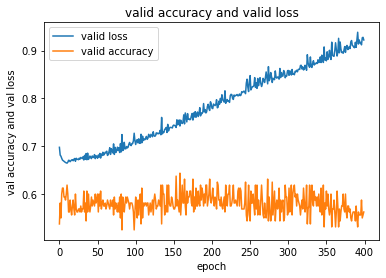

In [55]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('valid accuracy and valid loss')
plt.ylabel('val accuracy and val loss')
plt.xlabel('epoch')
plt.legend(['valid loss', 'valid accuracy'])
plt.show()